# Imports and Setup
installing and importing necessary libaries & functions, setting hardware & random seed 

In [ ]:
pip install torch torchvision captum memory_profiler opencv-python transformers

In [2]:
import sys
import os

# Add the project root to sys.path if not already included
project_root = os.path.abspath(".")

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from datasets.dataset_loader import load_data, transform_no_resize
from models.model_loader import load_model
from utils.benchmark_utils import measure_memory, calculate_energy
from utils.LIME_saving_results import save_experiment_results

import importlib    
import torch
import numpy as np
import statistics
import matplotlib.pyplot as plt
import importlib.util

In [ ]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
# Set a seed for reproducibility
seed = 24
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)

# Experimental Configuration
define parameters here for your *LIME* analysis:
* **n_segments**:   sets the number of superpixels used to segment the image
* **n_samples**:    governs the number of perturbed samples generated for explanation (exhibits the strongest influence on runtime and energy)
* **compactness**:  which adjusts the balance between spatial proximity and color similarity in superpixel formation
* **sigma**:        influences the smoothness of superpixel boundaries through a Gaussian kernel

In [4]:
# Choose the dataset
data_type = 'ImageNet'  # CIFAR10, STL10, URL, ImageNet
num_images = 100
model_name = 'resnet50'  # 'resnet50', 'densenet121', 'efficientnet-b0', 'convnext-t', 'vit-b-16'
gpu_name = "RTX-2080-Ti" #  GTX-1050, RTX-2080-Ti, P100, K80, Tesla-T4, Intel-Core-i7-9700K, AMD-Ryzen-5-3600, default-CPU
xai_method = "LIME2"  

# Choose the hyperparameters for LIME
n_segments = 50
n_samples = 100
compactness = 10.0
sigma = 1.0

# below are examples used in research
# n_segments_values = [10, 30, 50, 80, 100]
# n_samples_values = [50, 100, 200, 400]
# compactness_values = [5.0, 10.0, 20.0, 30.0]
# sigma_values = [0.5, 1.0, 2.0, 3.0]

# Choose the number of visualizations
num_visualizations = 3

Using device: cuda


In [7]:
image_urls = [
   # here you can add the URLs of the images you want to use
] if data_type == 'URL' else None

## Data and Model Loading

In [8]:
# LIME images does not require resizing
transform = transform_no_resize


# Check if using URL-based data first
if data_type == 'URL':
    # For URL data, use the image_urls parameter and load as usual
    num_images = len(image_urls)

    print("Loading URL data without class filtering for local method.")
    data_source, labels = load_data(data_type=data_type, num_images=num_images, image_urls=image_urls, transform=transform)
else:
    # For other datasets (e.g., CIFAR10, STL10)
    print("Loading CIFAR10/STL10 data without class filtering for local method.")
    data_source, labels = load_data(data_type=data_type, num_images=num_images, transform=transform)


# Count and display loaded images per class if applicable
if data_type in ['CIFAR10', 'STL10']:
    class_counts = {}
    for _, label in data_source:
        label_name = labels[label.item()]  # Get the class name for readability
        if label_name in class_counts:
            class_counts[label_name] += 1
        else:
            class_counts[label_name] = 1

    # Print the summary of loaded images per class
    print("Loaded image counts per class:")
    for class_name, count in class_counts.items():
        print(f"  {class_name}: {count} images")
else:
    # For URL data, we don't have class labels
    print("Loaded URL images without class labels.")

Loading CIFAR10/STL10 data without class filtering for local method.
Loaded URL images without class labels.


In [9]:
# Set the number of images to visualize
if data_type == 'URL':
    num_visualizations = num_images
elif data_type == 'CIFAR10':
    num_visualizations = 1
else:
    num_visualizations = 3

model = load_model(model_name=model_name, device=device)

## Dynamic XAI Method Import

In [10]:
# Base directory containing the subdirectories with XAI methods
base_dir = "xai_methods"
sub_dirs = ["LIME_variations"] 

# Function to dynamically import the specified XAI method
def load_xai_method(xai_method):
    for sub_dir in sub_dirs:
        method_path = os.path.join(base_dir, sub_dir, f"{xai_method}.py")  
        if os.path.isfile(method_path):  # Check if the file exists
            # Load module from the specified path
            spec = importlib.util.spec_from_file_location(xai_method, method_path)
            method_module = importlib.util.module_from_spec(spec)
            spec.loader.exec_module(method_module)
            print(f"Successfully loaded {xai_method} from {sub_dir}")
            return method_module
    raise ModuleNotFoundError(f"{xai_method} not found in any of the specified directories.")

# Load the XAI method module
method_module = load_xai_method(xai_method)

# Retrieve necessary functions from the XAI method module
generate_attribution = method_module.generate_attribution
measure_avg_time_across_images = method_module.measure_avg_time_across_images

# Optional visualization function (if exists in the module)
visualize_attribution = getattr(method_module, 'visualize_attribution', None)
visualize_aggregated_attribution = getattr(method_module, 'visualize_aggregated_attribution', None)

Successfully loaded LIME2 from LIME_variations


### Warm-Up for Stability

In [11]:
# Optional warm-up
if hasattr(method_module, 'warm_up'):
    method_module.warm_up(model)

## Main Run for Time, Memory and Visualizations

In [12]:
avg_time_taken, times = measure_avg_time_across_images(
    data_source, model, generate_attribution,
    n_segments=n_segments, n_samples=n_samples,
    compactness=compactness, sigma=sigma
)
print(f"Average time taken across {len(data_source)} images: {avg_time_taken:.4f} seconds")

peak_memories = []
net_memory_changes = []
cached_visualizations = []

# Measure memory usage for each image, caching a few attributions for visualization
for idx, data in enumerate(data_source):
    image, label = data if isinstance(data, (tuple, list)) else (data, None)
    image = image.to(device)

    # Get predicted class
    with torch.no_grad():
        output = model(image)
        _, predicted_class = torch.max(output, 1)

    # Measure memory with generate_attribution
    peak_memory, net_memory_change = measure_memory(
        image, predicted_class, generate_attribution, model,
        n_segments=n_segments, n_samples=n_samples,
        compactness=compactness, sigma=sigma
    )
    #peak_memory, net_memory_change = measure_memory(image, predicted_class, generate_attribution, model)
    peak_memories.append(peak_memory)
    net_memory_changes.append(net_memory_change)

    # Cache a few attributions for visualization (done separately to not affect time and memory calculations)
    if idx < num_visualizations:
        attribution = generate_attribution(
            image, predicted_class, model,
            n_segments=n_segments, n_samples=n_samples,
            compactness=compactness, sigma=sigma
        )

        #attribution = generate_attribution(image, predicted_class, model)
        cached_visualizations.append((image, attribution, label))

    torch.cuda.empty_cache()  # Clear cache to avoid memory accumulation

Average time taken across 100 images: 0.4948 seconds


Saved visualization at experiment_results/LIME/visualizations/LIME2_resnet50_ImageNet_RTX-2080-Ti_img1.png


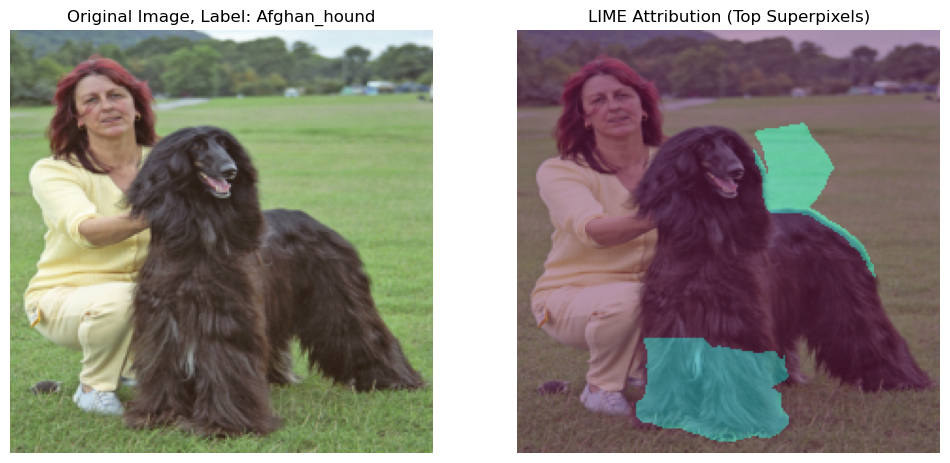

Saved visualization at experiment_results/LIME/visualizations/LIME2_resnet50_ImageNet_RTX-2080-Ti_img2.png


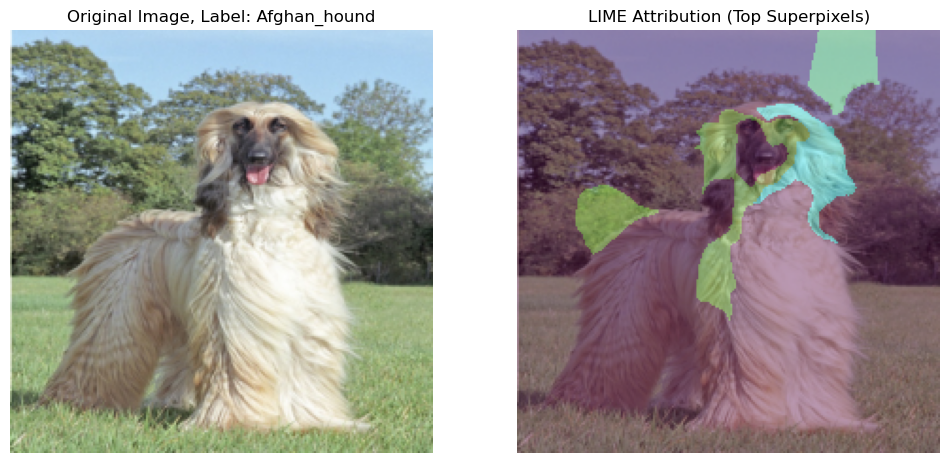

Saved visualization at experiment_results/LIME/visualizations/LIME2_resnet50_ImageNet_RTX-2080-Ti_img3.png


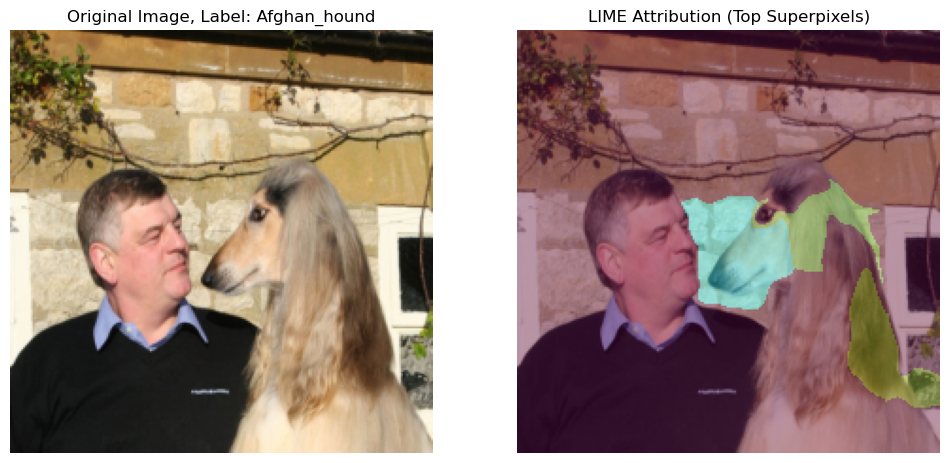

In [13]:
# Set up directory for visualizations if it doesn't exist
visualization_dir = "experiment_results/LIME/visualizations"
os.makedirs(visualization_dir, exist_ok=True)

if visualize_attribution:
    for i, (image, attribution, label) in enumerate(cached_visualizations):
        # Define the filename with a structured name for each individual visualization
        xai_method = "LIME2"
        visualization_filename = f"{visualization_dir}/{xai_method}_{model_name}_{data_type}_{gpu_name}_img{i+1}.png"
                    
        # Save the visualization using visualize_attribution (this will show it once per image)
        visualize_attribution(image, attribution, label, labels, save_path=visualization_filename)

### Statistical Summary

In [14]:
# Calculate averages and standard deviations
avg_peak_memory = sum(peak_memories) / len(peak_memories)
avg_net_memory_change = sum(net_memory_changes) / len(net_memory_changes)
std_time = statistics.stdev(times)
std_peak_memory = statistics.stdev(peak_memories)
std_net_memory_change = statistics.stdev(net_memory_changes)

# Calculate energy consumption based on average time and GPU name
energy_consumed_kWh, used_gpu_name = calculate_energy(avg_time_taken, gpu_name, xai_method)

# Print out the results
print("----------------------------------------------------------------------------")
print(f"Average time taken: {avg_time_taken:.4f} seconds (±{std_time:.4f})")
print(f"Average peak memory used: {avg_peak_memory:.4f} MiB (±{std_peak_memory:.4f})")
print(f"Average net memory change: {avg_net_memory_change:.4f} MiB (±{std_net_memory_change:.4f})")
print(f"Energy consumed: {energy_consumed_kWh:.4f} kWh")

Using...  Method: LIME2, Model: None, Device: RTX-2080-Ti, Power Usage: 250W
----------------------------------------------------------------------------
Average time taken: 0.4948 seconds (±0.0068)
Average peak memory used: 137.6719 MiB (±0.0000)
Average net memory change: 0.1914 MiB (±0.0000)
Energy consumed: 0.0344 kWh


### Save experimental results

In [15]:
# Example calculations for averages and standard deviations
avg_values = {
    "time": avg_time_taken,
    "peak_memory": avg_peak_memory,
    "net_memory_change": avg_net_memory_change
}

std_devs = {
    "time": std_time,
    "peak_memory": std_peak_memory,
    "net_memory_change": std_net_memory_change
}

# Create the summary dictionary
summary = {
    "energy_consumed_kWh": energy_consumed_kWh,
    "gpu_name": gpu_name,
    "num_images": num_images,
    "n_segments": n_segments,
    "n_samples": n_samples,
    "compactness": compactness,
    "sigma": sigma
}

# Create per-image results as before
per_image_results = [
    {"image_index": i, "time": time, "peak_memory": peak_mem, "net_memory_change": net_mem}
    for i, (time, peak_mem, net_mem) in enumerate(zip(times, peak_memories, net_memory_changes))
]

# Save the main experiment results
save_experiment_results(
    method=xai_method,
    n_segments=n_segments,
    model=model_name,
    dataset=data_type,
    summary=summary,
    per_image_results=per_image_results,
    avg_values=avg_values,
    std_devs=std_devs,
    n_samples=n_samples,
    compactness=compactness,
    sigma=sigma
)

Results saved in: experiment_results/LIME/per_image_results/LIME2_50s_100n_10.0c_3.0sig_resnet50_ImageNet_RTX-2080-Ti_run1.csv
